# random forest

In [1]:
import pandas as pd
from clearml import Task

In [5]:
import clearml
clearml.__version__

'1.5.0'

In [2]:
# task_ids = Task.query_tasks(project_name='zra/0407')
task_ids = Task.query_tasks(task_filter={'parent': "b5f9c93309b04ebc98497080d4584b0b"})

# task_ids = Task.get_tasks(project_name='zra/0407')
# task_id = task_ids.pop()
# task = Task.get_task(task_id)

In [ ]:

# task = Task.get_task("d3e5bcb46d2a4a25a5df5850fda375d7")

In [ ]:
# {'dataset': {'dataset_file_name': 'dataset_ws60.parquet',
#   'dataset_id': '5dc94de095014553acbe4f011a579241'},
#  'dataset_params': {'analog_group': '150',
#   'business_unit': 'all',
#   'log_target': 'True',
#   'scaler_kwargs': '',
#   'scaling': 'Standard',
#   'split_date': '01.01.2021',
#   'target_column_name_formatter': 'predict_normalized_{}',
#   'window_size': '120'},
#  'kflod_kwargs_params': {'n_splits': '5', 'shuffle': 'False'},
#  'model_kwargs_params': {'alpha': '1.0',
#   'max_depth': '20',
#   'n_estimators': '50'},
#  'model_type_params': {'model_type': 'RandomForestRegressor',
#   'save_kfold_predicts': 'True',
#   'save_model': 'False',
#   'use_kfold': 'False'}}

In [12]:
def make_dict(task_ids):
    all_data = []
    for task_id in task_ids:
        task = Task.get_task(task_id)
        if task.status!='completed':
            continue
        parameters = task.get_parameters_as_dict()
        scalars = task.get_reported_scalars()
                
        mae = scalars['month']['mae']
        mae = pd.Series(index=mae['x'], data=mae['y'], name=mae['name'])
        rmse = scalars['month']['rmse']
        rmse = pd.Series(index=rmse['x'], data=rmse['y'], name=rmse['name'])

        all_data.append((parameters, (mae, rmse)))
    return all_data


def parse_all_data(all_data):
    res = []

    for x in all_data:
        d = {}
        d['metrics'] = x[1]
        d['bu'] = x[0]['dataset_params']['business_unit']
        d['analog'] = x[0]['dataset_params']['analog_group']
        d['log_target'] = x[0]['dataset_params']['log_target']
        d['scaling'] = x[0]['dataset_params']['scaling']
        d['target_column_name_formatter'] = x[0]['dataset_params']['target_column_name_formatter']
        d['window_size'] = x[0]['dataset_params']['window_size']
        d['use_kfold'] = x[0]['model_type_params']['use_kfold']
        d['model_type'] = x[0]['model_type_params']['model_type']
        d['model_kwargs_params'] = x[0]['model_kwargs_params']
        d['max_depth'] = d['model_kwargs_params']['max_depth']
        d['n_estimators'] = d['model_kwargs_params']['n_estimators']
        res.append(d)
    return res

# def uniq_combinations(l: list, keys=['bu', 'analog']):
#     return set(map(lambda x: tuple([x[key] for key in keys]), l))

def make_res_df(res):
    res_df = pd.DataFrame(list(map(lambda x: {key: value for key, value in x.items() if key!='metrics'}, res)))
    res_df = res_df.merge(pd.concat(list(map(lambda x: x['metrics'][0], res)), axis=1).T.rename({i: f'mae_{i}' for i in range(12)}, axis=1).reset_index(drop=True), left_index=True, right_index=True)
    res_df = res_df.merge(pd.concat(list(map(lambda x: x['metrics'][1], res)), axis=1).T.rename({i: f'rmse_{i}' for i in range(12)}, axis=1).reset_index(drop=True), left_index=True, right_index=True)
    return res_df

def plot_metrics(res_df, groupby='analog'):
    mae_cols = [f'mae_{i}' for i in range(12)]
    rmse_cols = [f'rmse_{i}' for i in range(12)]
    for key, group in res_df.groupby(groupby):
        group[mae_cols].T.plot(legend=False, title=key, ylabel='mae')
        group[rmse_cols].T.plot(legend=False, title=key, ylabel='rmse')


In [3]:
# all_data_rf = []

# # for task_id in map(lambda x: x.task_id, task_ids):
# for task_id in task_ids:
#     task = Task.get_task(task_id)
#     # if task.status=='completed' and len(task.get_tags())>0:
#     if task.status=='completed' and task.parent=="b5f9c93309b04ebc98497080d4584b0b":
#         parameters = task.get_parameters_as_dict()
#         scalars = task.get_reported_scalars()
                
#         mae = scalars['month']['mae']
#         mae = pd.Series(index=mae['x'], data=mae['y'], name=mae['name'])
#         rmse = scalars['month']['rmse']
#         rmse = pd.Series(index=rmse['x'], data=rmse['y'], name=rmse['name'])

#         all_data_rf.append((parameters, (mae, rmse)))

all_data_rf = make_dict(task_ids)


In [5]:
all_data_rf.__len__(), task_ids.__len__()

(769, 769)

In [13]:
res_rf = parse_all_data(all_data_rf)
res_df_rf = make_res_df(res_rf)

In [14]:
mae_cols = [f'mae_{i}' for i in range(12)]
rmse_cols = [f'rmse_{i}' for i in range(12)]

In [ ]:
# for key, group in res_df.groupby('analog'):
#     # print(group.shape)
#     # break
#     group[mae_cols].plot()
#     group[rmse_cols].plot()

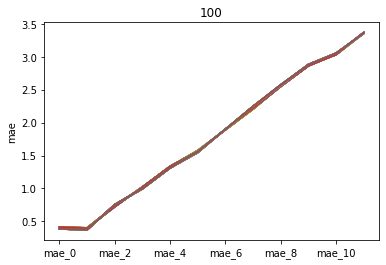

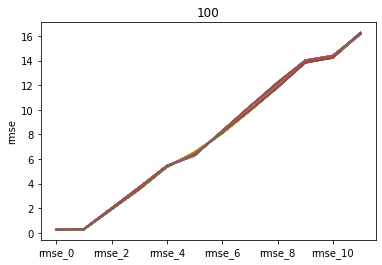

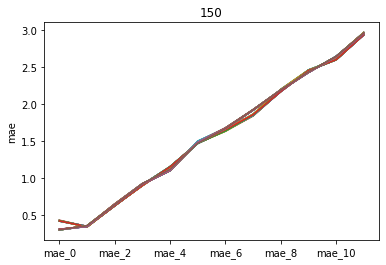

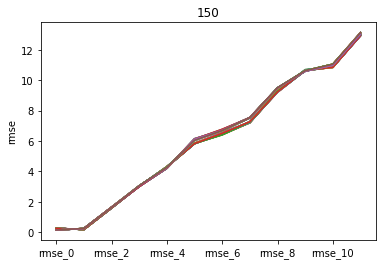

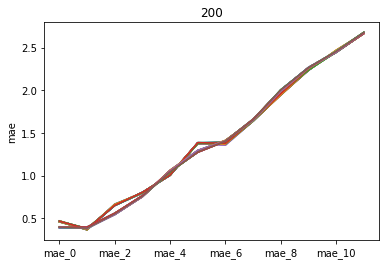

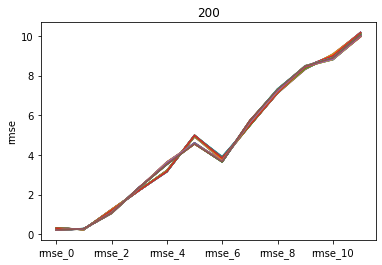

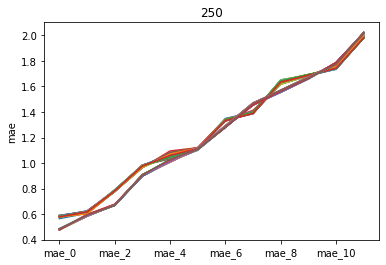

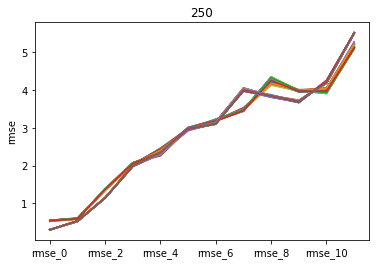

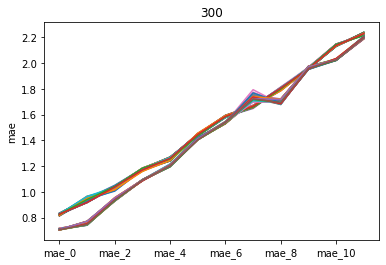

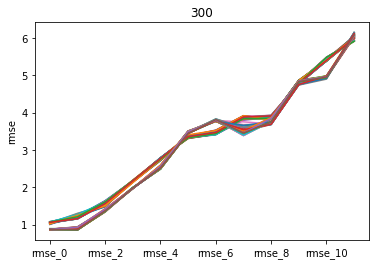

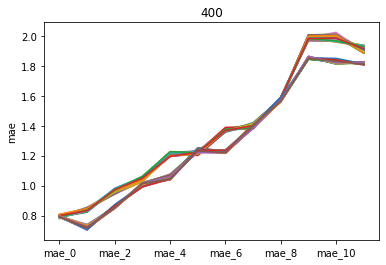

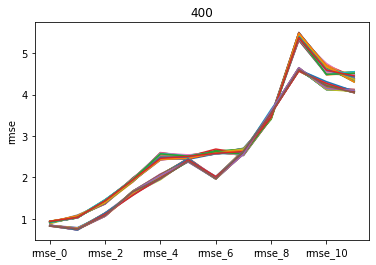

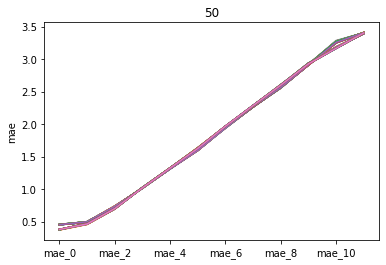

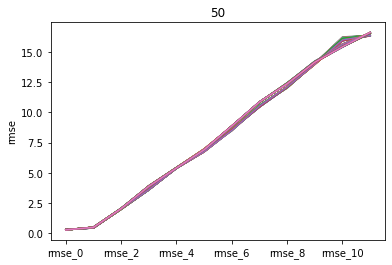

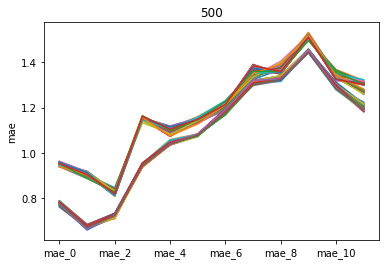

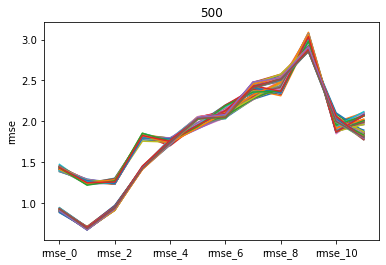

In [15]:
# for key, group in res_df.groupby('analog'):
#     # print(group.shape)
#     # break
#     group[mae_cols].T.plot(legend=False, title=key, ylabel='mae')
#     group[rmse_cols].T.plot(legend=False, title=key, ylabel='rmse')

plot_metrics(res_df_rf)

# catboost

In [18]:
task_ids_cb = Task.query_tasks(task_filter={'parent': "9950fc7379eb4cd29d95701c713d3444"})

In [19]:
all_data_cb = make_dict(task_ids_cb)


In [21]:
all_data_cb.__len__(), task_ids_cb.__len__()

(143, 145)

In [23]:
res_cb = parse_all_data(all_data_cb)
res_df_cb = make_res_df(res_cb)

In [24]:
res_df_cb

,bu,analog,log_target,scaling,target_column_name_formatter,window_size,use_kfold,model_type,model_kwargs_params,max_depth,...,rmse_2,rmse_3,rmse_4,rmse_5,rmse_6,rmse_7,rmse_8,rmse_9,rmse_10,rmse_11
0,all,50,False,Standard,predict_normalized_{},120,False,CatBoostRegressor,"{'alpha': '1.0', 'l2_leaf_reg': '0.01', 'max_d...",5,...,1.991668,3.779294,5.345428,6.886910,8.956405,10.693062,12.140849,13.678087,15.186211,16.608238
1,all,50,False,Standard,predict_normalized_{},120,False,CatBoostRegressor,"{'alpha': '1.0', 'l2_leaf_reg': '0.01', 'max_d...",2,...,1.961696,3.748933,5.483774,7.092350,9.043131,10.747395,12.299480,13.915739,15.645856,16.722307
2,all,50,False,Standard,predict_normalized_{},120,False,CatBoostRegressor,"{'alpha': '1.0', 'l2_leaf_reg': '0.01', 'max_d...",5,...,1.990924,3.780423,5.374591,6.906200,8.901775,10.685768,12.211713,13.634480,15.257698,16.623417
3,all,50,False,Standard,predict_normalized_{},120,False,CatBoostRegressor,"{'alpha': '1.0', 'l2_leaf_reg': '0.01', 'max_d...",5,...,1.993451,3.764382,5.347898,6.964257,8.936436,10.726551,12.157537,13.652460,15.254672,16.562437
4,all,50,False,Standard,predict_normalized_{},120,False,CatBoostRegressor,"{'alpha': '1.0', 'l2_leaf_reg': '0.01', 'max_d...",10,...,2.012543,3.719114,5.281191,6.846942,8.655465,10.429627,11.971000,13.406245,14.889292,16.564075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,all,500,False,Standard,predict_normalized_{},120,False,CatBoostRegressor,"{'alpha': '1.0', 'l2_leaf_reg': '1', 'max_dept...",2,...,0.940257,1.335701,1.887523,2.313951,2.381285,2.640756,2.300420,3.086290,2.315779,2.500442
139,all,500,False,Standard,predict_normalized_{},120,False,CatBoostRegressor,"{'alpha': '1.0', 'l2_leaf_reg': '1', 'max_dept...",5,...,0.857707,1.311149,1.736608,2.023373,2.331359,2.275521,2.443668,2.919039,2.159188,2.356550
140,all,500,False,Standard,predict_normalized_{},120,False,CatBoostRegressor,"{'alpha': '1.0', 'l2_leaf_reg': '1', 'max_dept...",5,...,0.851492,1.307967,1.705922,2.051159,2.314613,2.308502,2.458719,2.869506,2.204789,2.409698
141,all,500,False,Standard,predict_normalized_{},120,False,CatBoostRegressor,"{'alpha': '1.0', 'l2_leaf_reg': '1', 'max_dept...",10,...,0.851430,1.168689,1.557023,1.829792,2.016388,2.066153,2.258893,2.624312,2.319410,2.530526


In [33]:
res_df = pd.concat([res_df_cb, res_df_rf]).reset_index(drop=True)

In [34]:
res_df

,bu,analog,log_target,scaling,target_column_name_formatter,window_size,use_kfold,model_type,model_kwargs_params,max_depth,...,rmse_2,rmse_3,rmse_4,rmse_5,rmse_6,rmse_7,rmse_8,rmse_9,rmse_10,rmse_11
0,all,50,False,Standard,predict_normalized_{},120,False,CatBoostRegressor,"{'alpha': '1.0', 'l2_leaf_reg': '0.01', 'max_d...",5,...,1.991668,3.779294,5.345428,6.886910,8.956405,10.693062,12.140849,13.678087,15.186211,16.608238
1,all,50,False,Standard,predict_normalized_{},120,False,CatBoostRegressor,"{'alpha': '1.0', 'l2_leaf_reg': '0.01', 'max_d...",2,...,1.961696,3.748933,5.483774,7.092350,9.043131,10.747395,12.299480,13.915739,15.645856,16.722307
2,all,50,False,Standard,predict_normalized_{},120,False,CatBoostRegressor,"{'alpha': '1.0', 'l2_leaf_reg': '0.01', 'max_d...",5,...,1.990924,3.780423,5.374591,6.906200,8.901775,10.685768,12.211713,13.634480,15.257698,16.623417
3,all,50,False,Standard,predict_normalized_{},120,False,CatBoostRegressor,"{'alpha': '1.0', 'l2_leaf_reg': '0.01', 'max_d...",5,...,1.993451,3.764382,5.347898,6.964257,8.936436,10.726551,12.157537,13.652460,15.254672,16.562437
4,all,50,False,Standard,predict_normalized_{},120,False,CatBoostRegressor,"{'alpha': '1.0', 'l2_leaf_reg': '0.01', 'max_d...",10,...,2.012543,3.719114,5.281191,6.846942,8.655465,10.429627,11.971000,13.406245,14.889292,16.564075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,all,500,True,MinMax,predict_normalized_{},120,False,RandomForestRegressor,"{'alpha': '1.0', 'max_depth': '10', 'n_estimat...",10,...,0.917022,1.411382,1.726173,2.041463,2.061509,2.453817,2.539857,2.906891,2.000375,1.827926
908,all,500,True,MinMax,predict_normalized_{},120,False,RandomForestRegressor,"{'alpha': '1.0', 'max_depth': '10', 'n_estimat...",10,...,0.939781,1.433829,1.734477,2.031981,2.049799,2.406952,2.524546,2.871523,2.007425,1.833394
909,all,500,True,MinMax,predict_normalized_{},120,False,RandomForestRegressor,"{'alpha': '1.0', 'max_depth': '20', 'n_estimat...",20,...,0.941958,1.451674,1.768118,2.038002,2.095600,2.427118,2.516371,2.881226,2.063469,1.782947
910,all,500,True,MinMax,predict_normalized_{},120,False,RandomForestRegressor,"{'alpha': '1.0', 'max_depth': '20', 'n_estimat...",20,...,0.926679,1.429265,1.724077,2.044145,2.083878,2.480224,2.532956,2.911575,2.011011,1.792165


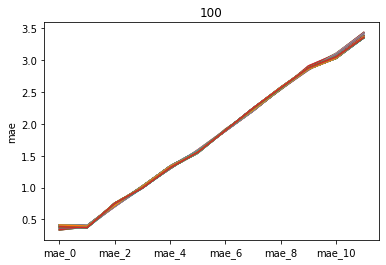

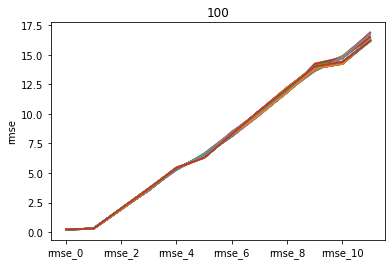

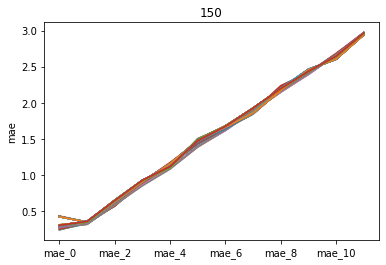

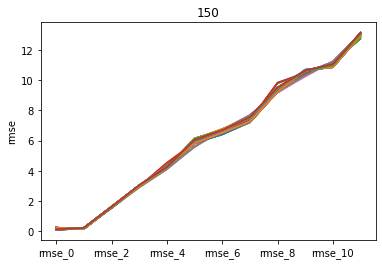

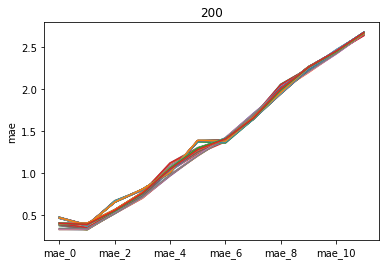

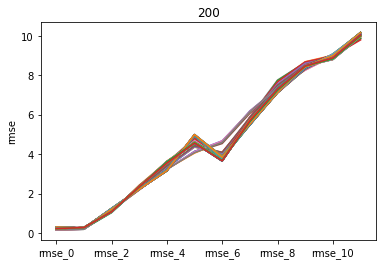

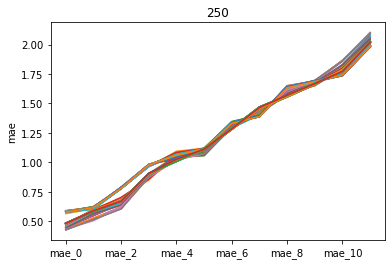

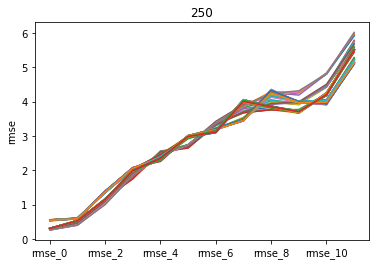

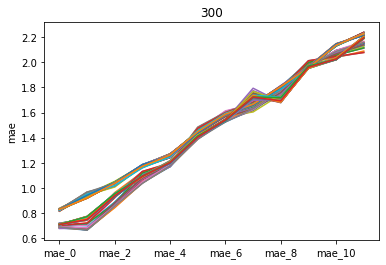

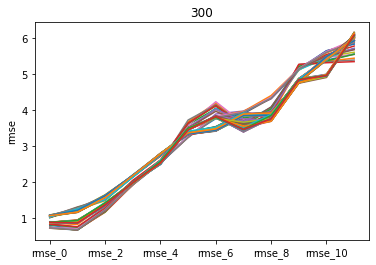

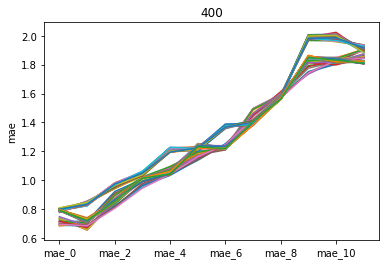

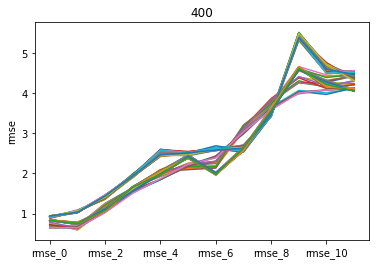

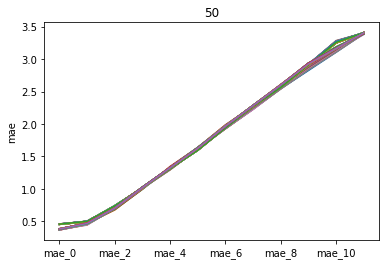

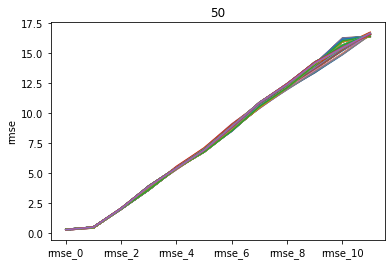

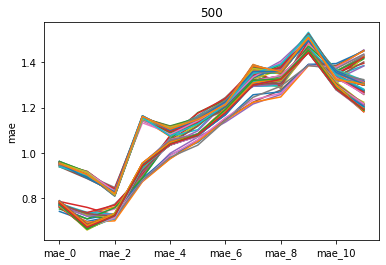

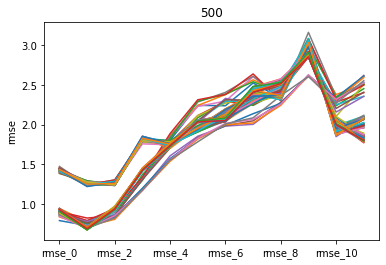

In [27]:
plot_metrics(res_df)

In [57]:
df.loc[idxmin]

bu                                                                            all
analog                                                                        500
log_target                                                                  False
scaling                                                                    MinMax
target_column_name_formatter                                predict_normalized_{}
window_size                                                                   120
use_kfold                                                                   False
model_type                                                  RandomForestRegressor
model_kwargs_params             {'alpha': '1.0', 'max_depth': '20', 'n_estimat...
max_depth                                                                      20
n_estimators                                                                   50
mae_0                                                                    0.789337
mae_1           

In [58]:
res = []

for key, df in res_df.groupby('analog'):
    for metric in ['mae', 'rmse']:
        for month in range(12):
            t = f"{metric}_{month}"
            # print(key, t, df.loc[df[t].idxmin()][['model_type']].values[0])
            idxmin = df[t].idxmin()
            res.append((key, metric, month, idxmin, df.loc[idxmin]['model_type'], df.loc[idxmin]['window_size']))

res = pd.DataFrame(res, columns=['bu', 'metric', 'month', 'idxmin', 'model_type', 'window_size'])

In [59]:
res.head()

,bu,metric,month,idxmin,model_type,window_size
0,100,mae,0,19,CatBoostRegressor,120
1,100,mae,1,301,RandomForestRegressor,60
2,100,mae,2,34,CatBoostRegressor,120
3,100,mae,3,27,CatBoostRegressor,120
4,100,mae,4,23,CatBoostRegressor,120


In [53]:
res['model_type'].value_counts(normalize=True)

CatBoostRegressor        0.65625
RandomForestRegressor    0.34375
Name: model_type, dtype: float64

In [50]:
res.groupby(['bu', 'metric']).agg({'model_type': 'value_counts'})

model_type
bu  metric model_type                       
100 mae    CatBoostRegressor               7
           RandomForestRegressor           5
    rmse   RandomForestRegressor           8
           CatBoostRegressor               4
150 mae    CatBoostRegressor               9
           RandomForestRegressor           3
    rmse   CatBoostRegressor               8
           RandomForestRegressor           4
200 mae    CatBoostRegressor               9
           RandomForestRegressor           3
    rmse   CatBoostRegressor               7
           RandomForestRegressor           5
250 mae    CatBoostRegressor               6
           RandomForestRegressor           6
    rmse   CatBoostRegressor               7
           RandomForestRegressor           5
300 mae    CatBoostRegressor               9
           RandomForestRegressor           3
    rmse   CatBoostRegressor               6
           RandomForestRegressor           6
400 mae    CatBoostRegressor               9
           RandomForestRegressor           3
    rmse   CatBoostRegressor               8
           RandomForestRegressor           4
50  mae    CatBoostRegressor              11
           RandomForestRegressor           1
    rmse   CatBoostRegressor               8
           RandomForestRegressor           4
500 mae    CatBoostRegressor               9
           RandomForestRegressor           3
    rmse   CatBoostRegressor               9
           RandomForestRegressor           3

In [54]:
res.groupby(['month']).agg({'model_type': 'value_counts'})

model_type
month model_type                       
0     CatBoostRegressor              16
1     CatBoostRegressor              11
      RandomForestRegressor           5
2     CatBoostRegressor              15
      RandomForestRegressor           1
3     CatBoostRegressor              14
      RandomForestRegressor           2
4     CatBoostRegressor              12
      RandomForestRegressor           4
5     CatBoostRegressor              13
      RandomForestRegressor           3
6     RandomForestRegressor          10
      CatBoostRegressor               6
7     RandomForestRegressor          11
      CatBoostRegressor               5
8     CatBoostRegressor               9
      RandomForestRegressor           7
9     CatBoostRegressor              14
      RandomForestRegressor           2
10    RandomForestRegressor          11
      CatBoostRegressor               5
11    RandomForestRegressor          10
      CatBoostRegressor               6

In [62]:
res.groupby(['window_size']).agg({'model_type': ['value_counts']}).reset_index()

window_size             model_type             
                                     value_counts
0         120      CatBoostRegressor          126
1         120  RandomForestRegressor           32
2          60  RandomForestRegressor           34

In [63]:
126/(126+32+34)

0.65625

In [ ]:
res

,bu,metric,month,idxmin,model_type,window_size
0,100,mae,0,19,CatBoostRegressor,120
1,100,mae,1,301,RandomForestRegressor,60
2,100,mae,2,34,CatBoostRegressor,120
3,100,mae,3,27,CatBoostRegressor,120
4,100,mae,4,23,CatBoostRegressor,120
...,...,...,...,...,...,...
187,500,rmse,7,129,CatBoostRegressor,120
188,500,rmse,8,136,CatBoostRegressor,120
189,500,rmse,9,142,CatBoostRegressor,120
190,500,rmse,10,842,RandomForestRegressor,60


In [138]:
res_df

,bu,analog,log_target,scaling,target_column_name_formatter,window_size,use_kfold,model_type,model_kwargs_params,max_depth,...,rmse_2,rmse_3,rmse_4,rmse_5,rmse_6,rmse_7,rmse_8,rmse_9,rmse_10,rmse_11
0,all,50,False,Standard,predict_normalized_{},120,False,CatBoostRegressor,"{'alpha': '1.0', 'l2_leaf_reg': '0.01', 'max_d...",5,...,1.991668,3.779294,5.345428,6.886910,8.956405,10.693062,12.140849,13.678087,15.186211,16.608238
1,all,50,False,Standard,predict_normalized_{},120,False,CatBoostRegressor,"{'alpha': '1.0', 'l2_leaf_reg': '0.01', 'max_d...",2,...,1.961696,3.748933,5.483774,7.092350,9.043131,10.747395,12.299480,13.915739,15.645856,16.722307
2,all,50,False,Standard,predict_normalized_{},120,False,CatBoostRegressor,"{'alpha': '1.0', 'l2_leaf_reg': '0.01', 'max_d...",5,...,1.990924,3.780423,5.374591,6.906200,8.901775,10.685768,12.211713,13.634480,15.257698,16.623417
3,all,50,False,Standard,predict_normalized_{},120,False,CatBoostRegressor,"{'alpha': '1.0', 'l2_leaf_reg': '0.01', 'max_d...",5,...,1.993451,3.764382,5.347898,6.964257,8.936436,10.726551,12.157537,13.652460,15.254672,16.562437
4,all,50,False,Standard,predict_normalized_{},120,False,CatBoostRegressor,"{'alpha': '1.0', 'l2_leaf_reg': '0.01', 'max_d...",10,...,2.012543,3.719114,5.281191,6.846942,8.655465,10.429627,11.971000,13.406245,14.889292,16.564075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
907,all,500,True,MinMax,predict_normalized_{},120,False,RandomForestRegressor,"{'alpha': '1.0', 'max_depth': '10', 'n_estimat...",10,...,0.917022,1.411382,1.726173,2.041463,2.061509,2.453817,2.539857,2.906891,2.000375,1.827926
908,all,500,True,MinMax,predict_normalized_{},120,False,RandomForestRegressor,"{'alpha': '1.0', 'max_depth': '10', 'n_estimat...",10,...,0.939781,1.433829,1.734477,2.031981,2.049799,2.406952,2.524546,2.871523,2.007425,1.833394
909,all,500,True,MinMax,predict_normalized_{},120,False,RandomForestRegressor,"{'alpha': '1.0', 'max_depth': '20', 'n_estimat...",20,...,0.941958,1.451674,1.768118,2.038002,2.095600,2.427118,2.516371,2.881226,2.063469,1.782947
910,all,500,True,MinMax,predict_normalized_{},120,False,RandomForestRegressor,"{'alpha': '1.0', 'max_depth': '20', 'n_estimat...",20,...,0.926679,1.429265,1.724077,2.044145,2.083878,2.480224,2.532956,2.911575,2.011011,1.792165


In [142]:
res_df.groupby('analog')[['mae_0', 'mae_1', 'mae_2', 'mae_3',
       'mae_4', 'mae_5', 'mae_6', 'mae_7', 'mae_8', 'mae_9', 'mae_10',
       'mae_11']] \
        .min()

,mae_0,mae_1,mae_2,mae_3,mae_4,mae_5,mae_6,mae_7,mae_8,mae_9,mae_10,mae_11
analog,,,,,,,,,,,,
100,0.334435,0.369613,0.701178,0.990667,1.295600,1.540894,1.887043,2.203078,2.539377,2.845404,3.029751,3.352810
150,0.239788,0.317906,0.569435,0.851126,1.082368,1.387777,1.615688,1.844326,2.147621,2.389542,2.601824,2.939381
200,0.323787,0.318628,0.513310,0.698136,0.963758,1.203027,1.357003,1.637160,1.942272,2.197708,2.419136,2.638153
250,0.427231,0.506090,0.606402,0.852078,1.007465,1.056567,1.277923,1.386181,1.553772,1.649796,1.733787,1.978812
300,0.676138,0.664220,0.841665,1.036803,1.168957,1.387546,1.525429,1.604916,1.678839,1.951164,2.020796,2.078473
400,0.683985,0.655401,0.805340,0.945116,1.033674,1.137929,1.210386,1.378250,1.559583,1.735161,1.798945,1.804711
50,0.365298,0.441478,0.673363,0.991888,1.293067,1.593697,1.925955,2.225135,2.538958,2.824640,3.105959,3.379548
500,0.742659,0.660612,0.700922,0.873486,0.974614,1.034785,1.136377,1.216473,1.247472,1.385339,1.278932,1.181714


In [141]:
res_df.groupby('analog')[['rmse_0', 'rmse_1', 'rmse_2', 'rmse_3', 'rmse_4', 'rmse_5',
       'rmse_6', 'rmse_7', 'rmse_8', 'rmse_9', 'rmse_10', 'rmse_11']] \
        .min()

,rmse_0,rmse_1,rmse_2,rmse_3,rmse_4,rmse_5,rmse_6,rmse_7,rmse_8,rmse_9,rmse_10,rmse_11
analog,,,,,,,,,,,,
100,0.179191,0.271282,1.897026,3.510571,5.241019,6.270316,8.070714,9.888032,11.800898,13.598196,14.216491,16.136379
150,0.096533,0.168233,1.531093,2.893296,4.099400,5.575397,6.402386,7.194927,9.174230,10.228683,10.845515,12.729262
200,0.147723,0.182900,1.024944,2.181811,3.139531,4.049037,3.640061,5.473406,7.097308,8.253970,8.795872,9.792739
250,0.259533,0.396257,0.998681,1.750297,2.256851,2.648438,3.094198,3.438113,3.761101,3.662633,3.906196,5.088285
300,0.713847,0.663853,1.159059,1.915403,2.488545,3.234090,3.409734,3.387951,3.683986,4.740870,4.900848,5.340274
400,0.643655,0.590679,1.023829,1.504891,1.841393,2.092464,1.958471,2.527488,3.404079,3.979839,3.965112,4.041732
50,0.236385,0.401684,1.945300,3.567993,5.281191,6.733623,8.463841,10.384395,11.946063,13.356094,14.860937,16.338531
500,0.789162,0.670177,0.804969,1.168689,1.537429,1.783551,1.982155,2.004290,2.244400,2.608538,1.848757,1.772987


# Посмотрим на предикты, где не было логарифмирования

7c330a572c3f4f9c90c24f133a531b35 - 500
de0210eef5bc4d498c867b9f834ae4f5 - 100
dc0c9989cc714296a75332804513bd30 - 200

In [67]:
import pickle

In [74]:
# task = Task.get_task("7c330a572c3f4f9c90c24f133a531b35")
task = Task.get_task("de0210eef5bc4d498c867b9f834ae4f5")



In [75]:
path = task.artifacts['model_results'].get_local_copy()
with open(path, 'rb') as f:
    data = pickle.load(f)

In [76]:
target = task.get_parameters_as_dict()['dataset_params']['target_column_name_formatter']

months = len(data)

In [77]:
target

'predict_normalized_{}'

In [87]:
month = 9
true_pred = data[month]['X_test_with_predict'][[f"predict_{month}", target.format(month), 'model_predict']]
true_pred
# true_pred.plot()


,predict_9,predict_normalized_9,model_predict
231615,98.0,126.196774,5.152795
231616,121.0,126.389247,5.158086
231617,123.0,126.581720,5.150419
231618,98.0,126.774194,5.168418
231619,127.0,126.774194,5.147891
...,...,...,...
232096,0.0,0.000000,5.258050
232097,0.0,0.000000,5.219321
232098,0.0,0.000000,5.218204
232099,0.0,0.000000,5.258071


In [88]:
task = Task.get_task("dc0c9989cc714296a75332804513bd30")


In [89]:
path = task.artifacts['model_results'].get_local_copy()
with open(path, 'rb') as f:
    data = pickle.load(f)

In [90]:
target = task.get_parameters_as_dict()['dataset_params']['target_column_name_formatter']

months = len(data)

In [91]:
target

'predict_normalized_{}'

In [93]:
month = 0
true_pred = data[month]['X_test_with_predict'][[f"predict_{month}", target.format(month), 'model_predict']]
true_pred
# true_pred.plot()


,predict_0,predict_normalized_0,model_predict
241050,20.0,31.935484,4.156744
241051,33.0,31.935484,4.148356
241052,33.0,31.942396,4.162358
241053,33.0,31.949309,4.142364
241054,33.0,31.956221,4.134227
...,...,...,...
241531,49.0,80.735484,4.101086
241532,47.0,80.148387,4.068840
241533,46.0,79.561290,4.140667
241534,44.0,78.974194,4.127597


In [96]:
from sklearn.metrics import mean_squared_error

In [98]:
mean_squared_error(true_pred['predict_normalized_0'], true_pred['model_predict'])

3111.960733025054

# Для Василия

In [107]:
from functools import reduce

In [102]:
task = Task.get_task("9950fc7379eb4cd29d95701c713d3444")

In [105]:
parameters = task.get_parameters()

In [106]:
parameters

{'dataset/dataset_id': '5dc94de095014553acbe4f011a579241',
 'dataset/dataset_file_name': 'dataset_ws60.parquet',
 'dataset_params/business_unit': '3990',
 'dataset_params/analog_group': '150',
 'dataset_params/window_size': '60',
 'dataset_params/split_date': '01.01.2021',
 'dataset_params/target_column_name_formatter': 'predict_{}',
 'dataset_params/log_target': 'False',
 'dataset_params/scaling': 'Standard',
 'dataset_params/scaler_kwargs': '',
 'model_type_params/model_type': 'CatBoostRegressor',
 'model_type_params/use_kfold': 'True',
 'model_type_params/save_kfold_predicts': 'True',
 'model_type_params/save_model': 'False',
 'model_kwargs_params/alpha': '1.0',
 'model_kwargs_params/max_depth': '5',
 'model_kwargs_params/n_estimators': '100',
 'model_kwargs_params/l2_leaf_reg': '0.01',
 'kflod_kwargs_params/n_splits': '5',
 'kflod_kwargs_params/shuffle': 'False'}

In [117]:
task_ids_cb = Task.query_tasks(task_filter={'parent': "9950fc7379eb4cd29d95701c713d3444"})
analog_dict = dict()

for task_id in task_ids_cb:
    task = Task.get_task(task_id)
    parameters = task.get_parameters()
    analog = parameters['dataset_params/analog_group']
    if analog in analog_dict.keys():
        continue
    
    path = task.artifacts['model_results'].get_local_copy()
    with open(path, 'rb') as f:
        data = pickle.load(f)

    target = task.get_parameters_as_dict()['dataset_params']['target_column_name_formatter']

    months = len(data)
    preds = []
    for month in range(months):
        df = data[month]['X_test_with_predict'][['cut_date', 'model_predict']].rename({'model_predict': "predict_{}".format(month)}, axis=1)
        preds.append(df)
    preds = reduce(lambda a, b: a.merge(b, on='cut_date'), preds)
    analog_dict[analog] = preds

In [134]:
# с true

task_ids_cb = Task.query_tasks(task_filter={'parent': "9950fc7379eb4cd29d95701c713d3444"})
analog_dict = dict()

for task_id in task_ids_cb:
    task = Task.get_task(task_id)
    parameters = task.get_parameters()
    analog = parameters['dataset_params/analog_group']
    if analog in analog_dict.keys():
        continue
    
    path = task.artifacts['model_results'].get_local_copy()
    with open(path, 'rb') as f:
        data = pickle.load(f)

    target = task.get_parameters_as_dict()['dataset_params']['target_column_name_formatter']

    months = len(data)
    preds = []
    true = []
    for month in range(months):
        df = data[month]['X_test_with_predict'][['cut_date', 'model_predict']].rename({'model_predict': "predict_{}".format(month)}, axis=1)
        preds.append(df)

        df = data[month]['X_test_with_predict'][['cut_date', f'predict_{month}']].rename({f'predict_{month}': "true_{}".format(month)}, axis=1)
        true.append(df)
    preds = preds + true
    preds = reduce(lambda a, b: a.merge(b, on='cut_date'), preds)
    preds = preds.reset_index().rename(columns={'index': 'DN'})
    preds['DN'] = analog
    analog_dict[analog] = preds

In [135]:
analog_dict['500']

,DN,cut_date,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,...,true_2,true_3,true_4,true_5,true_6,true_7,true_8,true_9,true_10,true_11
0,500,2021-01-01,2.354233,2.592630,2.290679,2.401748,1.936334,2.325924,2.005315,2.532610,...,5.0,30.0,0.0,0.0,4.0,14.0,4.0,4.0,1.0,31.0
1,500,2021-01-02,2.383057,2.653011,2.295752,2.407103,1.955525,2.300032,1.979997,2.540273,...,5.0,30.0,0.0,4.0,0.0,14.0,5.0,3.0,1.0,31.0
2,500,2021-01-03,2.329398,2.602103,2.295752,2.407103,1.955525,2.300032,1.965417,2.553486,...,5.0,30.0,0.0,4.0,12.0,2.0,5.0,3.0,1.0,32.0
3,500,2021-01-04,2.394644,2.320152,2.306546,2.434999,2.217364,2.176140,1.724920,2.665708,...,5.0,30.0,0.0,4.0,12.0,3.0,7.0,0.0,1.0,32.0
4,500,2021-01-05,2.455856,2.300222,2.307072,2.449888,2.198449,2.259797,1.924399,2.778879,...,5.0,30.0,0.0,4.0,12.0,3.0,7.0,1.0,29.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,500,2022-04-27,2.243543,2.175731,2.306461,2.412029,2.348700,2.043554,2.042087,2.217912,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
482,500,2022-04-28,2.158400,2.208635,2.318339,2.386157,2.348700,2.065633,2.080958,2.177767,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
483,500,2022-04-29,2.113921,2.106231,2.330256,2.461650,2.355749,2.247666,2.131461,2.272046,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
484,500,2022-04-30,1.955915,2.148508,2.246052,2.412165,2.186990,2.214605,2.205354,2.089108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
# with open(r'D:\gpn\for_vasiliy.pkl', 'wb') as f:
#     pickle.dump(analog_dict, f)



In [121]:
for key in analog_dict:
    analog_dict[key]['DN'] = key



In [136]:
pd.concat(analog_dict.values()).reset_index(drop=True).to_excel(r'D:\gpn\for_vasiliy\for_vasiliy2.xlsx', index=0)

# look processing
analysis.ipunb


In [100]:
import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
from typing import List, Dict, Optional, Tuple, Union, Any
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from utils.preprocessing import init_scaler_original, init_scaler, columns_for_deletion

In [ ]:
def split_train_test(
    data_df: pd.DataFrame,
    business_unit: str,
    analog_group: str,
    window_size: int,
    split_date: datetime.date,
    n_predict: int,
    target_column_name_formatter: str,
    log_target: bool = False,
    scaling: Optional[str] = None,
    scaler_kwargs: Optional[Dict[str, Any]] = None,
    drop_not_scalable: bool = True
):
    """_summary_

    Args:
        data_df (pd.DataFrame): Preprocessed dataframe
        analog_group (Union[str, int]): Specific group of analogs.
        window_size (int): number of days used to create the dataset.
        split_date (datetime.date): day relative to which the train and test are divided.
        n_predict (int): What month is the prediction for.
        target_column_name_formatter (str): What value is predicted.
        log_target (bool, optional): whether to logarithm target or not. Defaults to False.
        scaling (Optional[str], optional): whether use specific scaling or not. Defaults to None.
        scaler_kwargs (Optional[Dict[str, Any]], optional): Scaler kwargs if needed. Defaults to None.
        drop_not_scalable (bool, optional): _description_. Defaults to True.

    Raises:
        ValueError: _description_

    Returns:
        _type_: _description_
    """
    if isinstance(split_date, str):
        # split_date = datetime.datetime.strptime(split_date, "%d.%m.%Y").date()
        split_date = pd.to_datetime(split_date)

    valid_scaling = ['MinMaxScaler', 'StandardScaler']
    valid_scaling += ['MinMax', 'Standard']

    target_column_name = target_column_name_formatter.format(n_predict)
    # if target_column_name not in data_df.columns:
    #     raise ValueError(f'Missed columns: {target_column_name}')

    # check scaling
    if scaling and scaling not in valid_scaling:
        raise ValueError("scaling_type must be one of %r." % valid_scaling)

    # tdf = data_df[(data_df['business_unit'] == business_unit) &
    #               (data_df['material_cd'] == analog_group) &
    #               (data_df['window_size'] == window_size)
    #               ]

    print(f"Unique window_sizes: {data_df['window_size'].unique()}")

    tdf = data_df[(data_df['business_unit'] == business_unit)]
    print(tdf.shape[0])
    tdf = tdf[tdf['material_cd'] == analog_group]
    print(tdf.shape[0])
    # tdf = tdf[tdf['window_size'] == window_size]
    # print(tdf.shape[0])


    # split to train and test
    date_to_split = split_date - relativedelta(days=30) * (n_predict + 1)
    date_split_query = tdf['cut_date'].dt.date < date_to_split

    # train_slice = tdf[date_split_query]
    # test_slice = tdf[~date_split_query]

    train_slice = tdf[tdf['cut_date'].dt.date < date_to_split]
    test_slice = tdf[tdf['cut_date'].dt.date >= split_date]

    # work around target
    y_train = train_slice[target_column_name]
    y_test = test_slice[target_column_name]

    if log_target:
        y_train = np.log1p(y_train)
        y_test = np.log1p(y_test)

    if scaler_kwargs is None or len(scaler_kwargs)==0:
        scaler_kwargs = {}
    # scaling, scaler = self.init_scaler(scaling, **scaler_kwargs)
    scaling, scaler = init_scaler_original(scaling, **scaler_kwargs)

    # delete cut_date, mtr_cd, business_unit, w_size, predicts
    columns_to_drop = ['cut_date', 'material_cd',
                       'business_unit', 'window_size']
    columns_to_drop += columns_for_deletion(tdf, startswith='predict')

    # X_train = train_slice.drop(columns_to_drop, axis=1)
    # X_test = test_slice.drop(columns_to_drop, axis=1)
    X_train = train_slice[:]
    X_test = test_slice[:]

    # # delete stock_bmu_count in sum_df dataset
    # if mtr_group == "all":
    #     X_train = X_train.drop(['stock_bmu_count'], axis=1)
    #     X_test = X_test.drop(['stock_bmu_count'], axis=1)
    print(f"Train Shape : {train_slice.shape}, Test Shape {test_slice.shape}")

    if X_train.shape[0]==0:
        return X_train, X_test, y_train, y_test

    # applying scaling
    if scaling:
        columns_list = X_train.columns
        columns_list_ = list(set(X_train.columns) - set(columns_to_drop))

        X_train_ = scaler.fit_transform(X_train[columns_list_])
        X_test_ = scaler.transform(X_test[columns_list_])

        X_train.loc[:, columns_list_] = X_train_
        X_test.loc[:, columns_list_] = X_test_

        # X_train = pd.DataFrame(
        #     X_train, columns=columns_list, index=train_slice.index)
        # X_test = pd.DataFrame(X_test, columns=columns_list,
        #                     index=test_slice.index)

        if not drop_not_scalable:
            for col in columns_to_drop:
                X_train[col] = train_slice[col]
                X_test[col] = test_slice[col]

    return X_train, X_test, y_train, y_test

In [144]:
month = 0
df = data[month]['X_test_with_predict']
df



,business_unit,material_cd,window_size,cut_date,in_bmu_fact_count_7_0,in_bmu_fact_count_7_1,in_bmu_fact_count_7_2,in_bmu_fact_count_7_3,in_bmu_fact_count_7_4,in_bmu_fact_count_7_5,...,spp_sum,bmu_request_stock_03_normalized,bmu_request_stock_RE_normalized,bmu_request_stock_14_normalized,bmu_request_stock_12_normalized,bmu_request_stock_other_normalized,bmu_request_spp0_0_normalized,bmu_request_spp0_1_normalized,bmu_request_spp0_9_normalized,model_predict
258033,all,500,60,2021-01-01,-0.533653,-0.569772,0.275098,3.669429,0.281169,-0.569114,...,-0.590241,1.027308,-0.581999,-0.625851,0.0,-0.276579,-0.624854,1.040461,-0.567633,2.354233
258034,all,500,60,2021-01-02,-0.533653,-0.569772,0.275098,3.669429,0.281169,-0.569114,...,-0.590241,1.027308,-0.581999,-0.625851,0.0,-0.276579,-0.624854,1.040461,-0.567633,2.383057
258035,all,500,60,2021-01-03,-0.533653,-0.569772,0.275098,3.669429,0.281169,-0.569114,...,-0.590241,1.027308,-0.581999,-0.625851,0.0,-0.276579,-0.624854,1.040461,-0.567633,2.329398
258036,all,500,60,2021-01-04,-0.533653,-0.569772,0.275098,3.669429,0.281169,-0.569114,...,-0.590241,1.027308,-0.581999,-0.625851,0.0,-0.276579,-0.624854,1.040461,-0.567633,2.394644
258037,all,500,60,2021-01-05,-0.533653,-0.569772,0.275098,1.972705,1.983079,-0.569114,...,-0.590241,1.027308,-0.581999,-0.625851,0.0,-0.276579,-0.624854,1.040461,-0.567633,2.455856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258514,all,500,60,2022-04-27,-0.533653,1.971954,-0.572452,1.124343,-0.569786,1.132643,...,-0.529748,0.059882,-0.581999,-0.625851,0.0,1.945780,0.872437,0.000311,-0.567633,2.243543
258515,all,500,60,2022-04-28,-0.533653,1.971954,-0.572452,1.124343,-0.569786,1.132643,...,-0.529748,0.059882,-0.581999,-0.625851,0.0,1.945780,0.872437,0.000311,-0.567633,2.158400
258516,all,500,60,2022-04-29,-0.533653,1.971954,-0.572452,1.124343,-0.569786,-0.569114,...,-0.529748,0.059882,-0.581999,-0.625851,0.0,1.945780,0.872437,0.000311,-0.567633,2.113921
258517,all,500,60,2022-04-30,-0.533653,1.971954,-0.572452,1.124343,-0.569786,-0.569114,...,-0.529748,0.059882,-0.581999,-0.625851,0.0,1.945780,0.872437,0.000311,-0.567633,1.955915


In [130]:
df['predict_0']

258033    0.0
258034    2.0
258035    2.0
258036    2.0
258037    2.0
         ... 
258514    8.0
258515    8.0
258516    8.0
258517    8.0
258518    0.0
Name: predict_0, Length: 486, dtype: float64

In [145]:
df.shape

(486, 110)

# mape

In [24]:
import pickle

In [8]:
task_ids = Task.query_tasks(task_filter={'parent': "b5f9c93309b04ebc98497080d4584b0b"})
task_id = task_ids.pop()

In [9]:
# task = Task.get_task(task_id)
task = Task.get_task("a9d8474580904ad8a70a7db35cb27bdf")

In [20]:
path = task.artifacts['model_results'].get_local_copy()

In [19]:
data

'C:/Users/user/.clearml/cache/storage_manager/global/f9f4b84c894aed5f53ea589d241eee77.model_results.pkl'

In [53]:
with open(path, 'rb') as f:
    df = pickle.load(f)

In [27]:
pd.DataFrame(df)

,0,1,2,3,4,5,6,7,8,9,10,11
columns_train_on,"[bmu_request_stock_other, out_bmu_sum_7_2, in_...","[bmu_request_stock_other, out_bmu_sum_7_2, in_...","[bmu_request_stock_other, out_bmu_sum_7_2, in_...","[bmu_request_stock_other, out_bmu_sum_7_2, in_...","[bmu_request_stock_other, out_bmu_sum_7_2, in_...","[bmu_request_stock_other, out_bmu_sum_7_2, in_...","[bmu_request_stock_other, out_bmu_sum_7_2, in_...","[bmu_request_stock_other, out_bmu_sum_7_2, in_...","[bmu_request_stock_other, out_bmu_sum_7_2, in_...","[bmu_request_stock_other, out_bmu_sum_7_2, in_...","[bmu_request_stock_other, out_bmu_sum_7_2, in_...","[bmu_request_stock_other, out_bmu_sum_7_2, in_..."
X_test_with_predict,business_unit material_cd window_size ...,business_unit material_cd window_size ...,business_unit material_cd window_size ...,business_unit material_cd window_size ...,business_unit material_cd window_size ...,business_unit material_cd window_size ...,business_unit material_cd window_size ...,business_unit material_cd window_size ...,business_unit material_cd window_size ...,business_unit material_cd window_size ...,business_unit material_cd window_size ...,business_unit material_cd window_size ...


In [39]:
len(df), len(df[0])

(12, 2)

In [32]:
df[0].keys(), df[1].keys()

(dict_keys(['columns_train_on', 'X_test_with_predict']),
 dict_keys(['columns_train_on', 'X_test_with_predict']))

In [42]:
task.get_parameters_as_dict()['dataset_params']['target_column_name_formatter']

'predict_normalized_{}'

In [58]:
df[1]['X_test_with_predict']#['predict_normalized_']

,business_unit,material_cd,window_size,cut_date,in_bmu_fact_count_7_0,in_bmu_fact_count_7_1,in_bmu_fact_count_7_2,in_bmu_fact_count_7_3,in_bmu_fact_count_7_4,in_bmu_fact_count_7_5,...,spp_sum,bmu_request_stock_03_normalized,bmu_request_stock_RE_normalized,bmu_request_stock_14_normalized,bmu_request_stock_12_normalized,bmu_request_stock_other_normalized,bmu_request_spp0_0_normalized,bmu_request_spp0_1_normalized,bmu_request_spp0_9_normalized,model_predict
258033,all,500,60,2021-01-01,0.5,0.5,0.6,1.0,0.6,0.5,...,0.546511,1.5,0.5,0.5,0.5,0.5,0.5,1.5,0.5,2.565874
258034,all,500,60,2021-01-02,0.5,0.5,0.6,1.0,0.6,0.5,...,0.546511,1.5,0.5,0.5,0.5,0.5,0.5,1.5,0.5,2.666124
258035,all,500,60,2021-01-03,0.5,0.5,0.6,1.0,0.6,0.5,...,0.546511,1.5,0.5,0.5,0.5,0.5,0.5,1.5,0.5,2.585056
258036,all,500,60,2021-01-04,0.5,0.5,0.6,1.0,0.6,0.5,...,0.546511,1.5,0.5,0.5,0.5,0.5,0.5,1.5,0.5,2.449739
258037,all,500,60,2021-01-05,0.5,0.5,0.6,0.8,0.8,0.5,...,0.546511,1.5,0.5,0.5,0.5,0.5,0.5,1.5,0.5,2.570577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258514,all,500,60,2022-04-27,0.5,0.8,0.5,0.7,0.5,0.7,...,0.558138,1.1,0.5,0.5,0.5,0.9,0.9,1.1,0.5,1.841494
258515,all,500,60,2022-04-28,0.5,0.8,0.5,0.7,0.5,0.7,...,0.558138,1.1,0.5,0.5,0.5,0.9,0.9,1.1,0.5,1.845634
258516,all,500,60,2022-04-29,0.5,0.8,0.5,0.7,0.5,0.5,...,0.558138,1.1,0.5,0.5,0.5,0.9,0.9,1.1,0.5,1.856038
258517,all,500,60,2022-04-30,0.5,0.8,0.5,0.7,0.5,0.5,...,0.558138,1.1,0.5,0.5,0.5,0.9,0.9,1.1,0.5,1.879577


In [ ]:
def mape(true, pred):
    return 100 * ((true-pred)/true).abs().mean()

In [60]:
for task_id in task_ids:
    task = Task.get_task(task_id)
    path = task.artifacts['model_results'].get_local_copy()
    with open(path, 'rb') as f:
        data = pickle.load(f)

    target = task.get_parameters_as_dict()['dataset_params']['target_column_name_formatter']

    months = len(data)
    # true_preds = []
    for month in range(months):
        model_true = {target.format(month): "model_true"}
        true_pred = data[month]['X_test_with_predict'].rename(model_true, axis=1)[['model_true', 'model_predict']]
        # true_preds.append(true_pred)
        true = true_pred['model_true']
        pred = true_pred['model_predict']
        mapes.append(mape(true, pred))
    break
        

    
        

In [67]:
all_data = []

# for task_id in map(lambda x: x.task_id, task_ids):
for task_id in task_ids:
    if task.status!='completed':
        continue
    task = Task.get_task(task_id)
    path = task.artifacts['model_results'].get_local_copy()
    with open(path, 'rb') as f:
        data = pickle.load(f)
    
    parameters = task.get_parameters_as_dict()
    scalars = task.get_reported_scalars()
            
    mae = scalars['month']['mae']
    mae = pd.Series(index=mae['x'], data=mae['y'], name=mae['name'])
    rmse = scalars['month']['rmse']
    rmse = pd.Series(index=rmse['x'], data=rmse['y'], name=rmse['name'])

    target = parameters['dataset_params']['target_column_name_formatter']
    months = len(data)
    mapes = []
    
    for month in range(months):
        model_true = {target.format(month): "model_true"}
        true_pred = data[month]['X_test_with_predict'].rename(model_true, axis=1)[['model_true', 'model_predict']]

        true = true_pred['model_true']
        pred = true_pred['model_predict']
        mapes.append(mape(true, pred))
    mapes = pd.Series(data=mapes, name='mape')

    all_data.append((parameters, (mae, rmse, mapes)))


In [66]:
def parse_all_data(all_data):
    res = []

    for x in all_data:
        d = {}
        d['metrics'] = x[1]
        d['bu'] = x[0]['dataset_params']['business_unit']
        d['analog'] = x[0]['dataset_params']['analog_group']
        d['log_target'] = x[0]['dataset_params']['log_target']
        d['scaling'] = x[0]['dataset_params']['scaling']
        d['target_column_name_formatter'] = x[0]['dataset_params']['target_column_name_formatter']
        d['window_size'] = x[0]['dataset_params']['window_size']
        d['use_kfold'] = x[0]['model_type_params']['use_kfold']
        d['model_type'] = x[0]['model_type_params']['model_type']
        d['model_kwargs_params'] = x[0]['model_kwargs_params']
        d['max_depth'] = d['model_kwargs_params']['max_depth']
        d['n_estimators'] = d['model_kwargs_params']['n_estimators']
        res.append(d)
    return res

# def uniq_combinations(l: list, keys=['bu', 'analog']):
#     return set(map(lambda x: tuple([x[key] for key in keys]), l))

def make_res_df(res):
    res_df = pd.DataFrame(list(map(lambda x: {key: value for key, value in x.items() if key!='metrics'}, res)))
    res_df = res_df.merge(pd.concat(list(map(lambda x: x['metrics'][0], res)), axis=1).T.rename({i: f'mae_{i}' for i in range(12)}, axis=1).reset_index(drop=True), left_index=True, right_index=True)
    res_df = res_df.merge(pd.concat(list(map(lambda x: x['metrics'][1], res)), axis=1).T.rename({i: f'rmse_{i}' for i in range(12)}, axis=1).reset_index(drop=True), left_index=True, right_index=True)
    return res_df



In [68]:
res = parse_all_data(all_data)
res_df = make_res_df(res)